In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Loading datasets...
Training samples: 10997
Test samples: 2123
Loading BanglaBERT model and tokenizer...
Normalizing data...
Training: 8797 samples
Validation: 2200 samples
Test: 2123 samples
Tokenizing datasets...


Tokenizing: 100%|██████████| 2123/2123 [00:01<00:00, 1529.79it/s]


BanglaBERT Large with BiLSTM model loaded successfully!

MODEL PARAMETERS
Total Parameters: 338,232,322
Trainable Parameters: 338,232,322
Trainable %: 100.0000%


STARTING TRAINING
Start time: 2025-08-06 06:11:47

Epoch 1/3
------------------------------


Training Epoch 1: 100%|██████████| 550/550 [11:22<00:00,  1.24s/it]


Average training loss: 0.4805
Training time: 11m 22s


Validating: 100%|██████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Loss: 0.3904
Validation Accuracy: 0.8438

Epoch 2/3
------------------------------


Training Epoch 2: 100%|██████████| 550/550 [11:21<00:00,  1.24s/it]


Average training loss: 0.3206
Training time: 11m 22s


Validating: 100%|██████████| 138/138 [00:57<00:00,  2.40it/s]


Validation Loss: 0.4829
Validation Accuracy: 0.8293

Epoch 3/3
------------------------------


Training Epoch 3: 100%|██████████| 550/550 [11:21<00:00,  1.24s/it]


Average training loss: 0.2019
Training time: 11m 22s


Validating: 100%|██████████| 138/138 [00:57<00:00,  2.39it/s]


Validation Loss: 0.5551
Validation Accuracy: 0.8451

TRAINING COMPLETED
End time: 2025-08-06 06:48:45
Total training time: 0h 36m 59s

Evaluating on Test Set...


Evaluating Test Set: 100%|██████████| 133/133 [00:55<00:00,  2.41it/s]



FINAL RESULTS SUMMARY
MODEL: BanglaBERT Large + BiLSTM

PARAMETERS:
  Total Parameters: 338,232,322
  Trainable Parameters: 338,232,322
  Trainable Percentage: 100.0000%

TRAINING TIME:
  Total Training Time: 0h 36m 59s
  Average Time per Epoch: 12m 20s

TEST SET PERFORMANCE:
  Accuracy: 0.7518 (75.18%)
  Macro Precision: 0.7460
  Macro Recall: 0.7251
  Macro F1-Score: 0.7308

CLASS-WISE METRICS:
  Positive:
    Precision: 0.7297
    Recall: 0.5955
    F1-Score: 0.6558
    Support: 843
  Negative:
    Precision: 0.7624
    Recall: 0.8547
    F1-Score: 0.8059
    Support: 1280

CONFUSION MATRIX:
  Predicted ->  Positive  Negative
  Positive           502        341
  Negative           186       1094

DETAILED CLASSIFICATION REPORT:
--------------------------------------------------
              precision    recall  f1-score   support

    Positive     0.7297    0.5955    0.6558       843
    Negative     0.7624    0.8547    0.8059      1280

    accuracy                         0.751

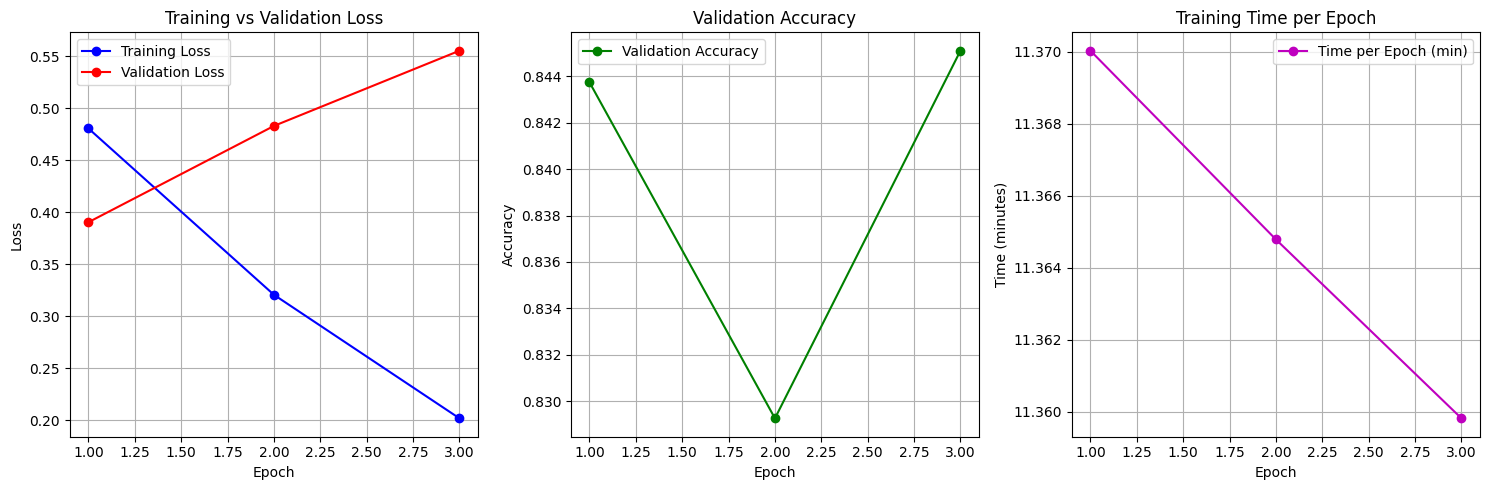

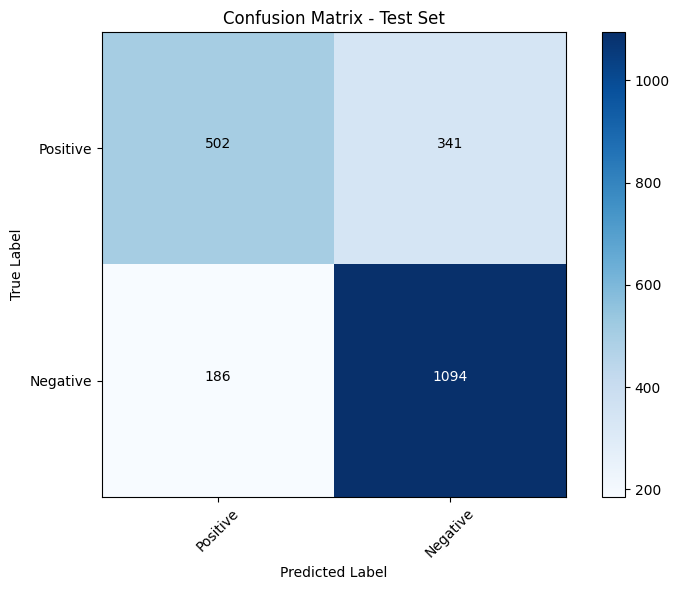


ANALYSIS COMPLETE!


In [1]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import time
from datetime import datetime

# Check GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Load datasets
print("Loading datasets...")
train_df = pd.read_csv('/content/drive/MyDrive/dataset/train2 (1).csv', encoding='utf-8', encoding_errors='ignore')
test_df = pd.read_csv('/content/drive/MyDrive/dataset/test2 (1).csv', encoding='utf-8', encoding_errors='ignore')

# Standardize column names
train_df.rename(columns={'Sentiment':'label', 'Data':'Text'}, inplace=True)
test_df.rename(columns={'Sentiment':'label', 'Data':'Text'}, inplace=True)
train_df = train_df[['label', 'Text']]
test_df = test_df[['label', 'Text']]

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Install required packages
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    from transformers import AutoModel, AutoTokenizer, AutoConfig
    from normalizer import normalize
except ImportError:
    print("Installing required packages...")
    install_package("transformers")
    install_package("git+https://github.com/csebuetnlp/normalizer")
    from transformers import AutoModel, AutoTokenizer, AutoConfig
    from normalizer import normalize

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Global variables for tracking
TOTAL_TRAINING_TIME = 0
TRAINABLE_PARAMS = 0
TOTAL_PARAMS = 0

# Initialize model and tokenizer
print("Loading BanglaBERT model and tokenizer...")
model_path = "csebuetnlp/banglabert_large"
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Normalize data
print("Normalizing data...")
train_df['Text'] = train_df['Text'].apply(normalize)
test_df['Text'] = test_df['Text'].apply(normalize)

# Create train-validation split
train_data, val_data = train_test_split(
    train_df, test_size=0.2, random_state=42, stratify=train_df['label']
)

print(f"Training: {len(train_data)} samples")
print(f"Validation: {len(val_data)} samples")
print(f"Test: {len(test_df)} samples")

# Tokenization function
def tokenize_data(sentences, labels, max_len=128):
    input_ids = []
    attention_masks = []

    for sent in tqdm(sentences, desc="Tokenizing"):
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels_tensor = torch.tensor(labels)

    return input_ids, attention_masks, labels_tensor

# Tokenize all datasets
print("Tokenizing datasets...")
train_input_ids, train_attention_masks, train_labels = tokenize_data(
    train_data.Text.values, train_data.label.values
)
val_input_ids, val_attention_masks, val_labels = tokenize_data(
    val_data.Text.values, val_data.label.values
)
test_input_ids, test_attention_masks, test_labels = tokenize_data(
    test_df.Text.values, test_df.label.values
)

# Create datasets and dataloaders
batch_size = 16

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Custom BanglaBERT with BiLSTM Model
class CustomBanglaBertWithBiLSTM(nn.Module):
    def __init__(self, model_name=model_path, num_labels=2, lstm_hidden_size=256, lstm_layers=1, dropout_rate=0.1):
        super(CustomBanglaBertWithBiLSTM, self).__init__()
        self.num_labels = num_labels

        # Load BanglaBERT model and its configuration
        self.config = AutoConfig.from_pretrained(model_name)
        self.config.num_labels = num_labels

        self.bert = AutoModel.from_pretrained(model_name)

        # BiLSTM layer
        self.lstm = nn.LSTM(
            input_size=self.config.hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            bidirectional=True,
            batch_first=True
        )

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Classification head
        self.classifier = nn.Linear(lstm_hidden_size * 2, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        # Forward pass through BanglaBERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)

        # Get the sequence output (last hidden states)
        sequence_output = outputs.last_hidden_state

        # Pass through BiLSTM
        lstm_output, _ = self.lstm(sequence_output)

        # Get the last time step output from both directions
        lstm_output = lstm_output[:, -1, :]

        # Apply dropout
        lstm_output = self.dropout(lstm_output)

        # Classification
        logits = self.classifier(lstm_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {"loss": loss, "logits": logits}

    def save_pretrained(self, output_dir):
        """Save the model weights and configuration."""
        os.makedirs(output_dir, exist_ok=True)
        model_to_save = self.module if hasattr(self, 'module') else self

        # Make parameters contiguous before saving
        for param in model_to_save.parameters():
            param.data = param.data.contiguous()

        torch.save(model_to_save.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))
        self.config.save_pretrained(output_dir)
        print(f"Model saved to {output_dir}")

# Load custom model for sequence classification
model = CustomBanglaBertWithBiLSTM(
    model_name=model_path,
    num_labels=2,  # Binary classification
    lstm_hidden_size=256,
    lstm_layers=1,
    dropout_rate=0.1
)

model.to(device)
print("BanglaBERT Large with BiLSTM model loaded successfully!")

# GET PARAMETER COUNTS
def get_parameter_counts(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n{'='*60}")
    print(f"MODEL PARAMETERS")
    print(f"{'='*60}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Trainable %: {100 * trainable_params / total_params:.4f}%")
    print(f"{'='*60}\n")

    return total_params, trainable_params

TOTAL_PARAMS, TRAINABLE_PARAMS = get_parameter_counts(model)

# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
)

# Training functions
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train_epoch(model, dataloader, optimizer, scheduler, device, epoch_num):
    model.train()
    total_loss = 0
    epoch_start_time = time.time()

    print(f"\nEpoch {epoch_num}/3")
    print("-" * 30)

    for step, batch in enumerate(tqdm(dataloader, desc=f"Training Epoch {epoch_num}")):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = result['loss']
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    epoch_time = time.time() - epoch_start_time

    print(f"Average training loss: {avg_loss:.4f}")
    print(f"Training time: {epoch_time//60:.0f}m {epoch_time%60:.0f}s")

    return avg_loss, epoch_time

def validate_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_accuracy = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            result = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = result['loss']
            logits = result['logits']

            total_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_accuracy += flat_accuracy(logits, label_ids)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation Accuracy: {avg_accuracy:.4f}")

    return avg_loss, avg_accuracy

# MAIN TRAINING LOOP
print(f"\n{'='*60}")
print(f"STARTING TRAINING")
print(f"{'='*60}")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

training_start_time = time.time()
training_stats = []

for epoch in range(epochs):
    train_loss, epoch_time = train_epoch(model, train_dataloader, optimizer, scheduler, device, epoch+1)
    val_loss, val_accuracy = validate_epoch(model, val_dataloader, device)

    training_stats.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'epoch_time': epoch_time
    })

TOTAL_TRAINING_TIME = time.time() - training_start_time

print(f"\n{'='*60}")
print(f"TRAINING COMPLETED")
print(f"{'='*60}")
print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total training time: {TOTAL_TRAINING_TIME//3600:.0f}h {(TOTAL_TRAINING_TIME%3600)//60:.0f}m {TOTAL_TRAINING_TIME%60:.0f}s")

# EVALUATION FUNCTION
def evaluate_model(model, dataloader, device, dataset_name):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    print(f"\nEvaluating on {dataset_name}...")

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {dataset_name}"):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            result = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = result['loss']
            logits = result['logits']

            total_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            pred_flat = np.argmax(logits, axis=1).flatten()
            predictions.extend(pred_flat)
            true_labels.extend(label_ids.flatten())

    avg_loss = total_loss / len(dataloader)

    return predictions, true_labels, avg_loss

# EVALUATE ON TEST SET
test_predictions, test_true_labels, test_loss = evaluate_model(model, test_dataloader, device, "Test Set")

# CALCULATE METRICS
accuracy = accuracy_score(test_true_labels, test_predictions)
precision, recall, f1, support = precision_recall_fscore_support(test_true_labels, test_predictions, average=None)
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(test_true_labels, test_predictions, average='macro')

# CONFUSION MATRIX
cm = confusion_matrix(test_true_labels, test_predictions)

# FINAL RESULTS
print(f"\n{'='*80}")
print(f"FINAL RESULTS SUMMARY")
print(f"{'='*80}")
print(f"MODEL: BanglaBERT Large + BiLSTM")
print(f"")
print(f"PARAMETERS:")
print(f"  Total Parameters: {TOTAL_PARAMS:,}")
print(f"  Trainable Parameters: {TRAINABLE_PARAMS:,}")
print(f"  Trainable Percentage: {100 * TRAINABLE_PARAMS / TOTAL_PARAMS:.4f}%")
print(f"")
print(f"TRAINING TIME:")
print(f"  Total Training Time: {TOTAL_TRAINING_TIME//3600:.0f}h {(TOTAL_TRAINING_TIME%3600)//60:.0f}m {TOTAL_TRAINING_TIME%60:.0f}s")
print(f"  Average Time per Epoch: {TOTAL_TRAINING_TIME/epochs//60:.0f}m {(TOTAL_TRAINING_TIME/epochs)%60:.0f}s")
print(f"")
print(f"TEST SET PERFORMANCE:")
print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Macro Precision: {macro_precision:.4f}")
print(f"  Macro Recall: {macro_recall:.4f}")
print(f"  Macro F1-Score: {macro_f1:.4f}")
print(f"")
print(f"CLASS-WISE METRICS:")
class_names = ['Positive', 'Negative']  # Changed from No Sarcasm/Sarcasm to Positive/Negative
for i, class_name in enumerate(class_names):
    print(f"  {class_name}:")
    print(f"    Precision: {precision[i]:.4f}")
    print(f"    Recall: {recall[i]:.4f}")
    print(f"    F1-Score: {f1[i]:.4f}")
    print(f"    Support: {support[i]}")
print(f"")
print(f"CONFUSION MATRIX:")
print(f"  Predicted ->  Positive  Negative")
print(f"  Positive        {cm[0,0]:6d}     {cm[0,1]:6d}")
print(f"  Negative        {cm[1,0]:6d}     {cm[1,1]:6d}")
print(f"{'='*80}")

# DETAILED CLASSIFICATION REPORT
print(f"\nDETAILED CLASSIFICATION REPORT:")
print(f"-" * 50)
report = classification_report(test_true_labels, test_predictions, target_names=class_names, digits=4)
print(report)

# TRAINING PROGRESS VISUALIZATION
training_df = pd.DataFrame(training_stats)
print(f"\nTRAINING PROGRESS:")
print(training_df.round(4))

# Plot training progress
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(training_df['epoch'], training_df['train_loss'], 'b-o', label='Training Loss')
plt.plot(training_df['epoch'], training_df['val_loss'], 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(training_df['epoch'], training_df['val_accuracy'], 'g-o', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(training_df['epoch'], training_df['epoch_time']/60, 'm-o', label='Time per Epoch (min)')
plt.title('Training Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (minutes)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print(f"ANALYSIS COMPLETE!")
print(f"{'='*80}")